In [1]:
!pip install numpy pandas matplotlib seaborn

In [28]:
#dataset info: https://github.com/allisonhorst/palmerpenguins/blob/main/README.md

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

import os
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def get_dataframes():
    dataframes = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            print(path)
            dataframes.append(pd.read_csv(path))
    return dataframes


df_size, df_lter = get_dataframes()
# print(df_size.columns)
# print(df_lter.columns)
df_size

/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv
/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_lter.csv


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


Вывести в табличной форме статистику по датасету

In [4]:
isnull_objects_percent =  round(df_size.isnull().any(axis=1).sum() / df_size.shape[0] * 100, 2)

dataset_stats_df = pd.DataFrame([
    ['size', df_size.shape],
    ['feautures', df_size.shape[1] - 1],
    ['classes num', df_size['species'].nunique()],
    ['isnull objects %', isnull_objects_percent]
], columns=['characteristics', 'value'])

class_counts = df_size['species'].value_counts().reset_index()
class_counts.columns = ['characteristics', 'value']

numeric_features = df_size.select_dtypes(include=['number']).columns
categorical_features = df_size.select_dtypes(include=['object']).columns

additional_info = pd.DataFrame([
    ['numeric features', len(numeric_features)],
    ['categorical features', len(categorical_features)]
], columns=['characteristics', 'value'])

dataset_stats_df = pd.concat([dataset_stats_df, class_counts, additional_info], ignore_index=True)

df_size.describe()
dataset_stats_df

,characteristics,value
0,size,"(344, 7)"
1,feautures,6
2,classes num,3
3,isnull objects %,2.91
4,Adelie,152
5,Gentoo,124
6,Chinstrap,68
7,numeric features,4
8,categorical features,3


In [5]:
df_size.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
df_size = df_size.dropna()
df_size.drop(columns=['sex', 'island'], inplace=True)
df_size

/tmp/ipykernel_36/224246325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_size.drop(columns=['sex', 'island'], inplace=True)


,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


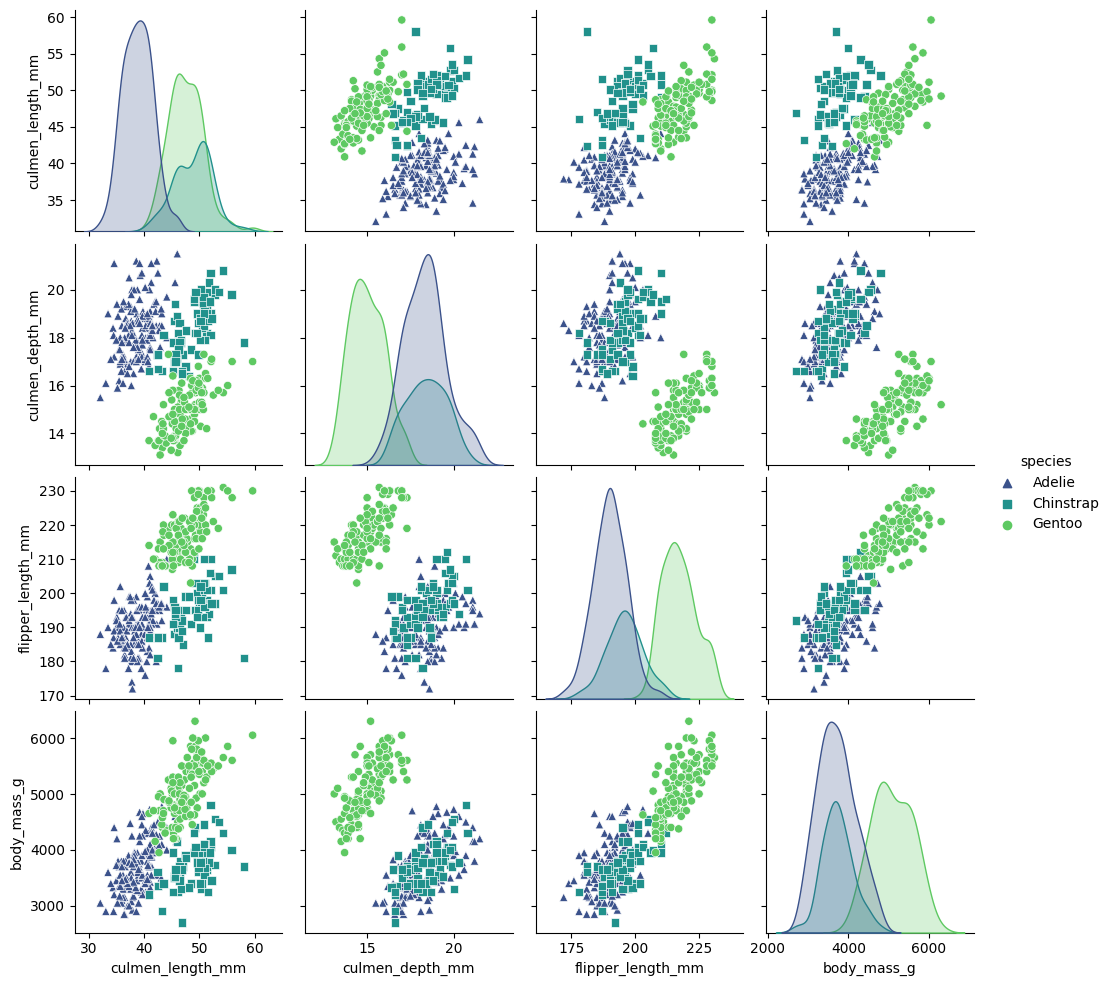

In [6]:
pair_plot = sns.pairplot(df_size, hue='species', palette='viridis', markers=['^', 's', 'o'])
plt.show()

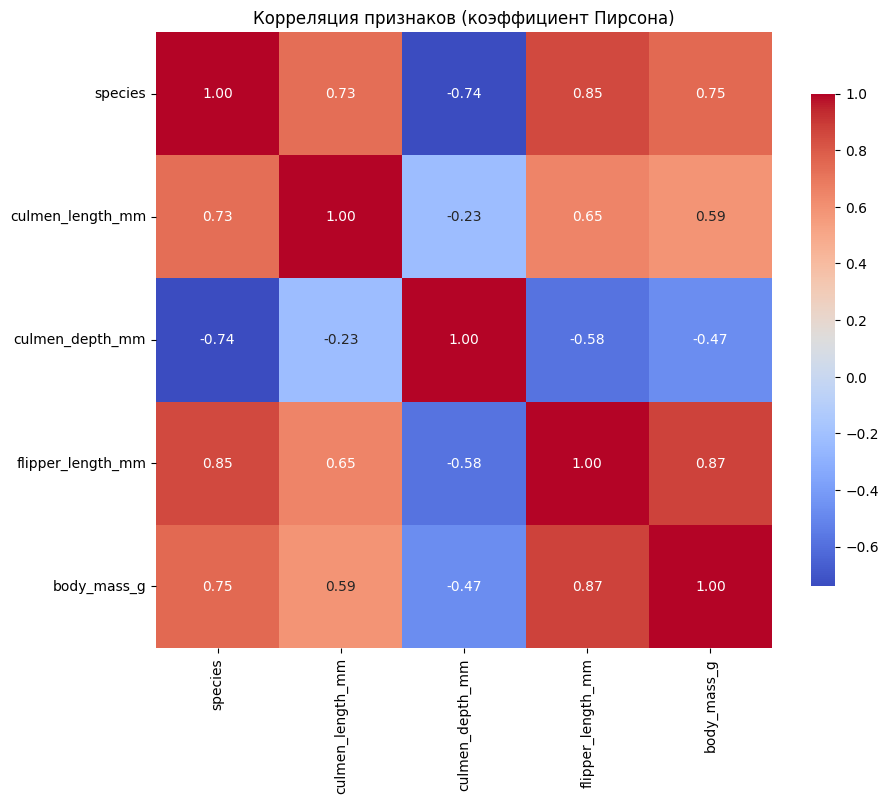

In [7]:
discrete_encoded_df = df_size.copy(deep=True)
discrete_encoded_df['species'] = df_size['species'].replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})

correlation_matrix = discrete_encoded_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция признаков (коэффициент Пирсона)')
plt.show()

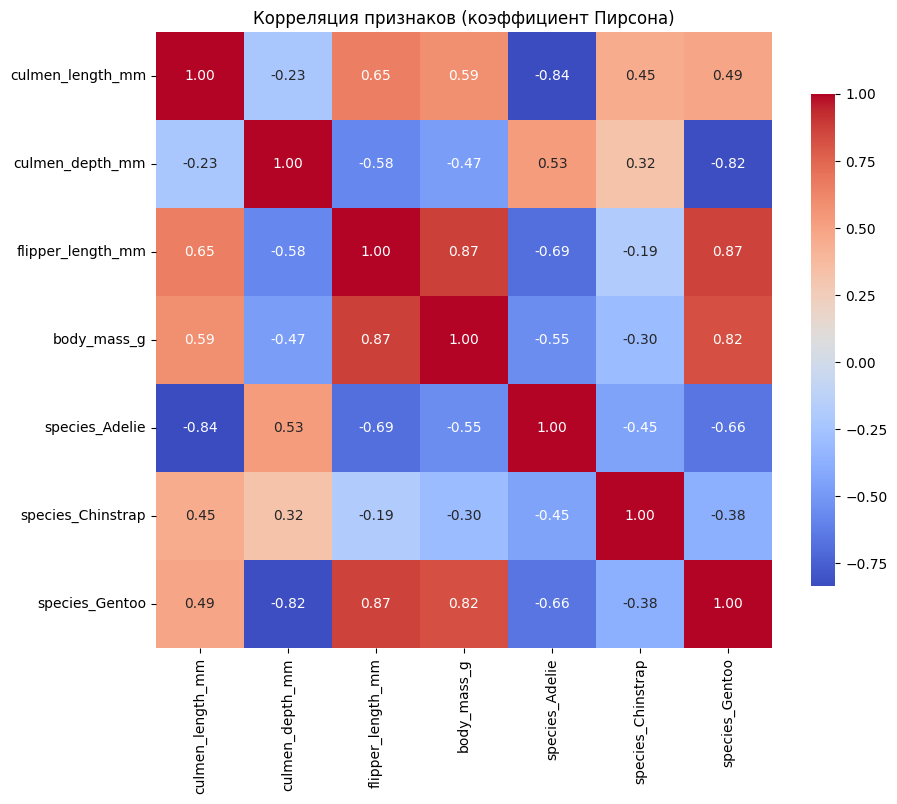

In [8]:
one_hot_df_size = pd.get_dummies(df_size, columns=['species'], drop_first=False)

correlation_matrix = one_hot_df_size.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция признаков (коэффициент Пирсона)')
plt.show()

In [9]:
df_size_two_classes = df_size.copy(deep=True)
df_size_two_classes.drop(df_size_two_classes[df_size_two_classes['species'] == 'Chinstrap'].index, inplace=True)
df_size_two_classes.rename(columns={'species': 'Adelie'}, inplace=True)
df_size_two_classes['Adelie'] = df_size['species'].replace({'Adelie': True, 'Gentoo': False})
df_size_two_classes['Adelie'] = df_size_two_classes['Adelie'].astype(bool)
df_size_two_classes

,Adelie,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,True,39.1,18.7,181.0,3750.0
1,True,39.5,17.4,186.0,3800.0
2,True,40.3,18.0,195.0,3250.0
4,True,36.7,19.3,193.0,3450.0
5,True,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,False,47.2,13.7,214.0,4925.0
340,False,46.8,14.3,215.0,4850.0
341,False,50.4,15.7,222.0,5750.0
342,False,45.2,14.8,212.0,5200.0


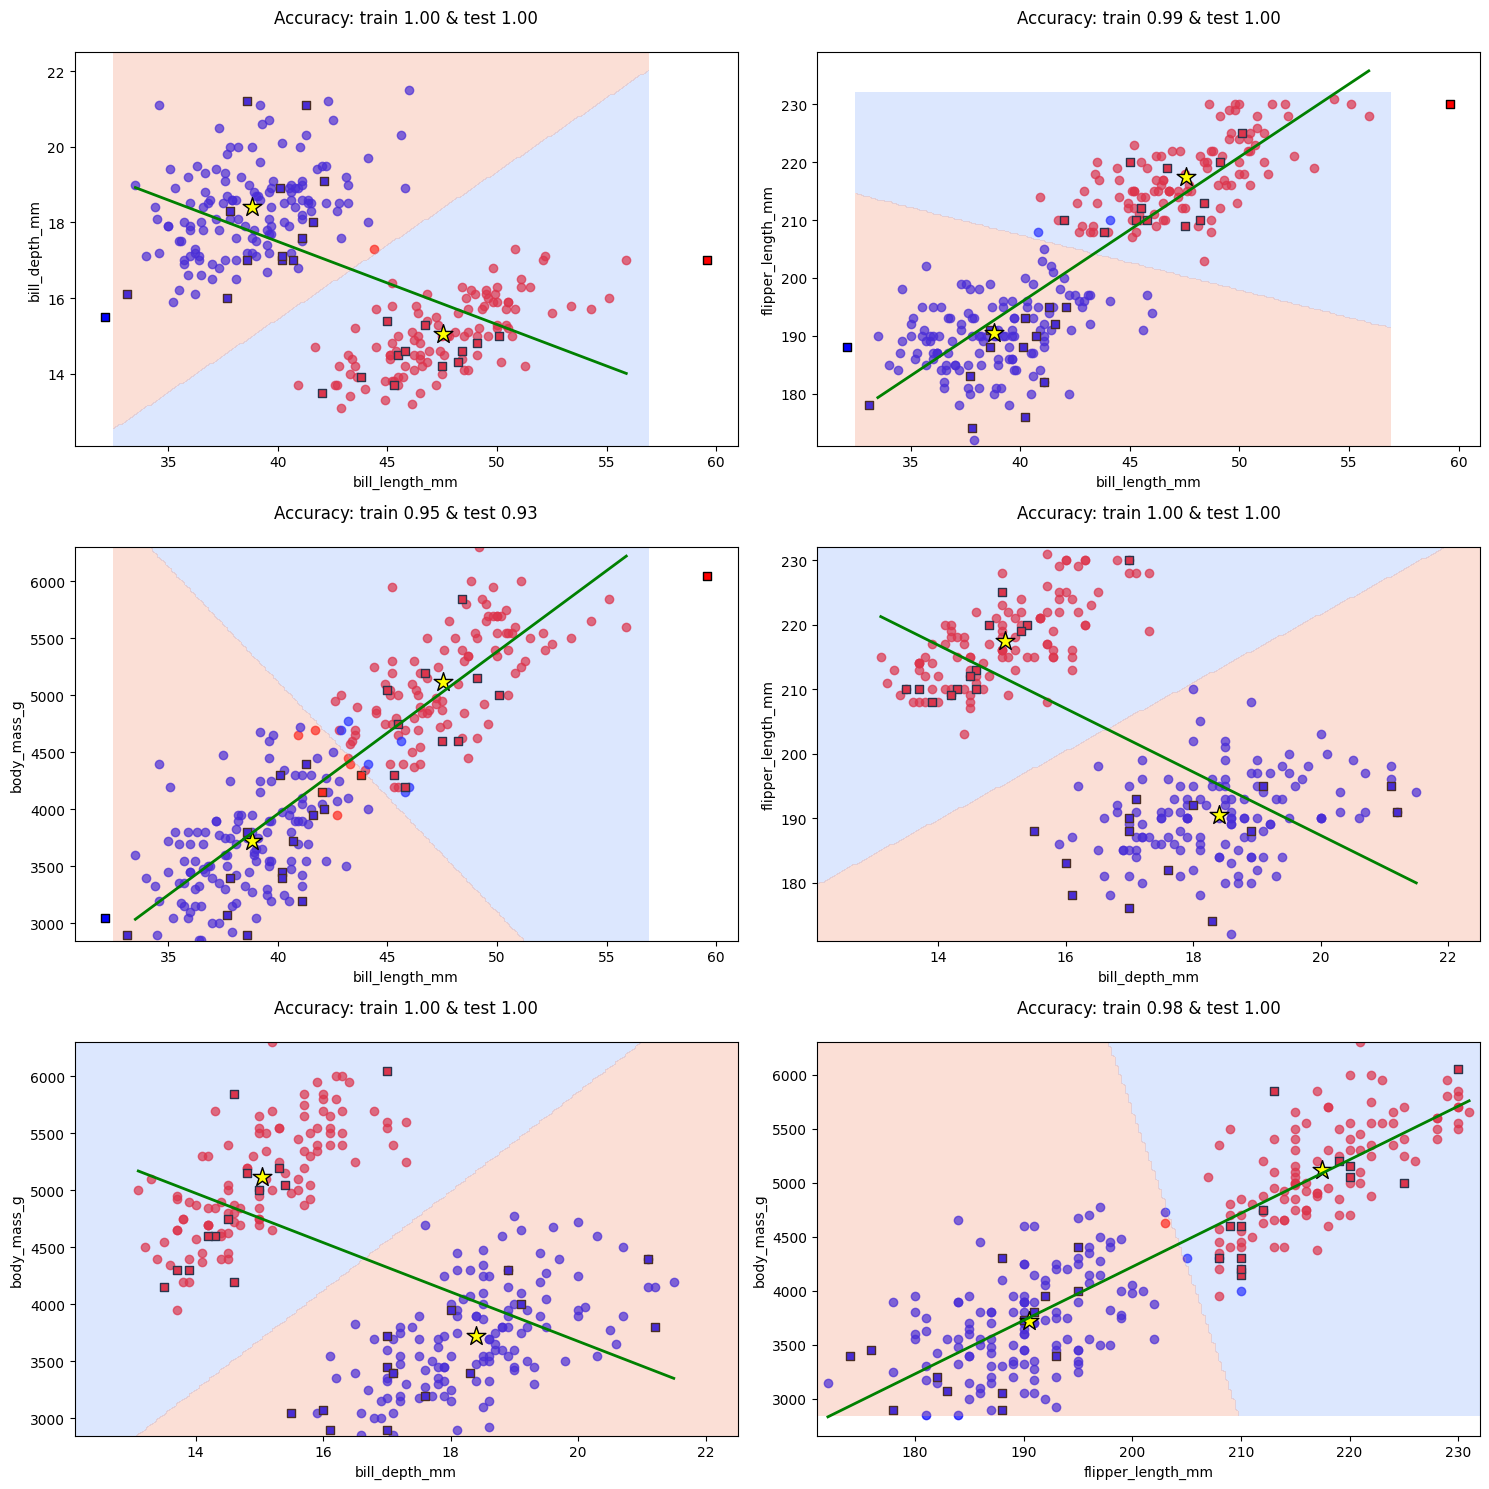

Average train accuracy: 0.9874
Average test accuracy: 0.9877


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
feature_pairs = list(combinations([0, 1, 2, 3], 2))
feature_pair_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


def plot_lda_for_feature_pair(lda, X_train, X_test, y_train, y_test, feature_pair, ax):
    X_train_pair = X_train[:, feature_pair]
    X_test_pair = X_test[:, feature_pair]

    lda.fit(X_train_pair, y_train)
    y_train_pred = lda.predict(X_train_pair)
    y_test_pred = lda.predict(X_test_pair)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    ax.scatter(X_train_pair[y_train == 0][:, 0], X_train_pair[y_train == 0][:, 1], color='red', marker='o', label='Gentoo - train', alpha=0.7)
    ax.scatter(X_train_pair[y_train == 1][:, 0], X_train_pair[y_train == 1][:, 1], color='blue', marker='o', label='Adelie - train', alpha=0.7)
    ax.scatter(X_test_pair[y_test == 0][:, 0], X_test_pair[y_test == 0][:, 1], color='red', marker='s', label='Gentoo - test', edgecolor='k')
    ax.scatter(X_test_pair[y_test == 1][:, 0], X_test_pair[y_test == 1][:, 1], color='blue', marker='s', label='Adelie - test', edgecolor='k')

    # Решающая граница
    x_min, x_max = X_train_pair[:, 0].min() - 1, X_train_pair[:, 0].max() + 1
    y_min, y_max = X_train_pair[:, 1].min() - 1, X_train_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    centroid_class_0 = X_train_pair[y_train == 0].mean(axis=0)
    centroid_class_1 = X_train_pair[y_train == 1].mean(axis=0)
    ax.scatter(centroid_class_0[0], centroid_class_0[1], color='yellow', marker='*', s=200, label='Centroid - Gentoo', edgecolor='black')
    ax.scatter(centroid_class_1[0], centroid_class_1[1], color='yellow', marker='*', s=200, label='Centroid - Adelie', edgecolor='black')
    
    lr = LinearRegression()
    lr.fit(X_train_pair[:, 0].reshape(-1, 1), X_train_pair[:, 1])
    line_x = np.linspace(X_train_pair[:, 0].min(), X_train_pair[:, 0].max(), 100)
    line_y = lr.predict(line_x.reshape(-1, 1))
    ax.plot(line_x, line_y, color='green', label='Linear regression', linewidth=2)

    ax.set_xlabel(feature_pair_names[feature_pair[0]])
    ax.set_ylabel(feature_pair_names[feature_pair[1]])
    ax.set_title(f"Accuracy: train {train_accuracy:.2f} & test {test_accuracy:.2f}\n")
    return train_accuracy, test_accuracy


fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

lda = LDA()

train_accuracies = []
test_accuracies = []


for i, feature_pair in enumerate(feature_pairs):
    train_acc, test_acc = plot_lda_for_feature_pair(lda, X_train, X_test, y_train, y_test, feature_pair, axes[i])
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

plt.tight_layout()
plt.show()

print(f"Average train accuracy: {np.mean(train_accuracies):.4f}")
print(f"Average test accuracy: {np.mean(test_accuracies):.4f}")